In [14]:
import pickle
from random import shuffle, seed
import numpy as np
from util import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore') # get rid of silly sklearn warnings

seed("sahai uwu")

In [15]:
# ppath = "/Volumes/scottf/mimic_processed/preproced.bin"
ppath = "/Volumes/scottf/mimic_processed/preproced_neg.bin"
#ppath = "/Volumes/scottd/mimic_processed/preproced_discharge.bin"
data = pickle.load(open(ppath, 'rb')) # Tuples of (text, label) where label is 0 or 1
shuffle(data)

split_point = int(0.8 * len(data)) # Use 80% of our data for training and the rest for testing
train = data[:split_point]
test = data[split_point:]

train_data = [t[0] for t in train]
train_labels = [t[1] for t in train]
test_data = [t[0] for t in test]
test_labels = [t[1] for t in test]

print("Number of training samples: " + str(len(train)))
print("Number of test samples: " + str(len(test)))
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

Number of training samples: 5361
Number of test samples: 1341
(array([0, 1]), array([3070, 2291]))
(array([0, 1]), array([787, 554]))


Accuracy: 0.8575689783743475


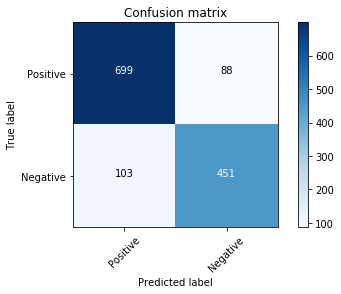

0.11181702668360864
0.8140794223826715
[0.41312453 0.83673469 1.        ]
[1.         0.81407942 0.        ]


In [16]:
# The first classification technique we will try is SVM on TF-IDF vectors
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

classifier = make_pipeline(CountVectorizer(ngram_range=(2,2)), TfidfTransformer(), SGDClassifier(loss='hinge', penalty='l2', alpha=0.0005, max_iter=100)) 
classifier.fit(train_data, train_labels)

predictions = classifier.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

fpr, tpr, _ = roc_curve(test_labels, predictions, pos_label=1)
print(fpr[1])
print(tpr[1])

precision, recall, _ = precision_recall_curve(test_labels, predictions)
print(precision)
print(recall)



['term infant' 'stable open_crib' 'swaddled warmer' 'pink well'
 'ad_lib demand' 'ct screen' 'transfer newborn_nursery' 'infant pink'
 'lung fluid' 'dusky spells' 'transfer note' 'prior transfer' 'ap term'
 'retained_fetal lung' 'newborn_intensive care' 'cont monitor'
 'remains single_phototherapy' 'air isolette' 'servo isolette'
 'eye_shields place' 'infant remains' 'repeat bilirubin' 'recheck bili'
 'bili infant' 'enteral feeds' 'repeat bili' 'check bili' 'fam meeting'
 'bili level' 'bili blanket']


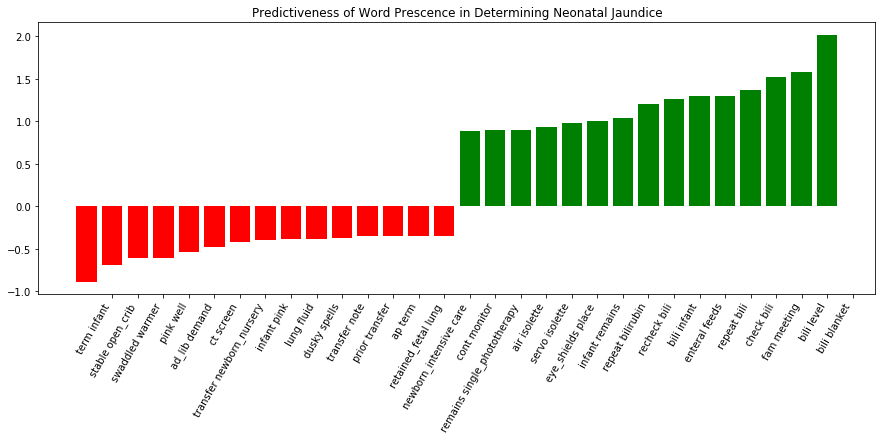

In [17]:
def plot_coefficients(classifier, feature_names, top_features=15):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'green' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    print(feature_names[top_coefficients])
    plt.title('Predictiveness of Word Prescence in Determining Neonatal Jaundice')
    plt.savefig("predictiveness.png")
    plt.show()
    
plot_coefficients(classifier.named_steps['sgdclassifier'], classifier.named_steps['countvectorizer'].get_feature_names())

In [9]:
classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), SGDClassifier(loss='hinge', penalty='l2', alpha=0.0005, max_iter=100)) 
scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
print(scores.mean())

classifier = make_pipeline(CountVectorizer(), SGDClassifier(loss='hinge', penalty='l2', alpha=0.0005, max_iter=100)) 
scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
print(scores.mean())

KeyboardInterrupt: 

In [ ]:
# SVC
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix

classifier = make_pipeline(CountVectorizer(ngram_range=(0,2)), TfidfTransformer(), svm.SVC(C=100, kernel='linear'))
classifier.fit(train_data, train_labels)

predictions = classifier.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

fpr, tpr, _ = roc_curve(test_labels, predictions, pos_label=1)
print(fpr[1])
print(tpr[1])

precision, recall, _ = precision_recall_curve(test_labels, predictions)
print(precision)
print(recall)


Accuracy: 0.8


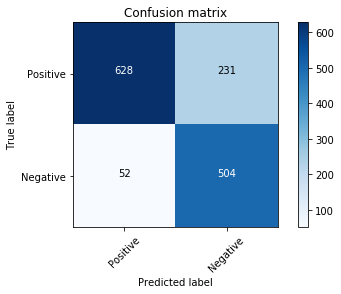

In [4]:
# Next, try k-Nearest Neighbors on TF-IDF vectors
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), KNeighborsClassifier(n_neighbors=5)) 
classifier.fit(train_data, train_labels)

predictions = classifier.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), KNeighborsClassifier(n_neighbors=5)) 
scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
scores.mean()

Accuracy: 0.8663366336633663


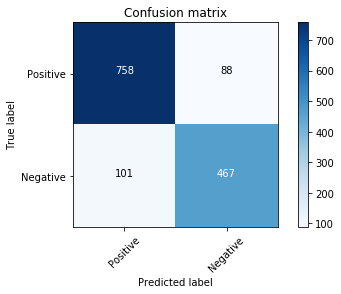

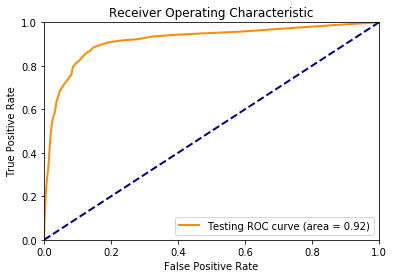

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/scott/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-fd52e52eeff7>", line 39, in <module>
    scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
  File "/Users/scott/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 342, in cross_val_score
    pre_dispatch=pre_dispatch)
  File "/Users/scott/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 206, in cross_validate
    for train, test in cv.split(X, y, groups))
  File "/Users/scott/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/Users/scott/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
 

KeyboardInterrupt: 

In [18]:
# Random Forests
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), RandomForestClassifier(n_estimators=32)) 
classifier.fit(train_data, train_labels)

predictions = classifier.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

class_probs = classifier.predict_proba(test_data)
conf = [c[1] for c in class_probs]

fpr, tpr, thresholds = roc_curve(test_labels, conf, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

classifier = make_pipeline(CountVectorizer(ngram_range=(0,2)), TfidfTransformer(), RandomForestClassifier(n_estimators=16)) 
scores = cross_val_score(classifier, train_data + test_data, train_labels + test_labels, cv=10)
scores.mean()

In [ ]:
# AdaBoost
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

gridSearch = False
if gridSearch:
    classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), AdaBoostClassifier())
    params = {'adaboostclassifier__n_estimators' : [32, 64], 'countvectorizer__ngram_range' : [(1, 1), (1, 2), (2, 2)]}
    clf = GridSearchCV(classifier, params, n_jobs=-1)
else:
    classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), AdaBoostClassifier(n_estimators=50)) 
    clf = classifier

clf.fit(train_data, train_labels)

print(clf.best_score_)
print(clf.best_params_)

predictions = clf.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

class_probs = clf.predict_proba(test_data)
conf = [c[1] for c in class_probs]

fpr, tpr, thresholds = roc_curve(test_labels, conf, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
    
scores = cross_val_score(clf, train_data + test_data, train_labels + test_labels, cv=10)
scores.mean()

0.904686118479222
{'adaboostclassifier__n_estimators': 32, 'countvectorizer__ngram_range': (1, 1)}
Accuracy: 0.8988684582743989


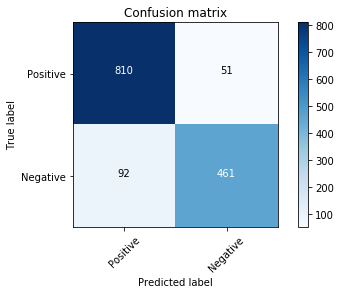

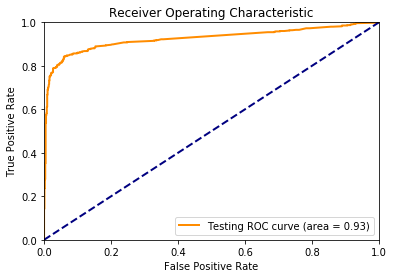

Process ForkPoolWorker-8:
Process ForkPoolWorker-7:


KeyboardInterrupt: 

In [4]:
print(clf.best_score_)
print(clf.best_params_)

predictions = clf.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

class_probs = clf.predict_proba(test_data)
conf = [c[1] for c in class_probs]

fpr, tpr, thresholds = roc_curve(test_labels, conf, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
    
scores = cross_val_score(clf, train_data + test_data, train_labels + test_labels, cv=10)
scores.mean()

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

predictions = classifier.predict(test_data)

print("Accuracy: " + str(accuracy_score(test_labels, predictions)))
p, r, f, _ = precision_recall_fscore_support(test_labels, predictions)
print("Precision: " + str(p))
print("Recall: " + str(r))
print("F1: " + str(f))

Accuracy: 0.8575689783743475
Precision: [0.87157107 0.83673469]
Recall: [0.88818297 0.81407942]
F1: [0.87979862 0.8252516 ]
